<a href="https://colab.research.google.com/github/kuberiitb/retail_price_ai_agent/blob/main/RetailPriceAgent_DataCreation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain langchain_community langchain-openai langgraph --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 7.0 MB/s eta 0:00:00


In [ ]:
!apt-get install sqlite3

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  sqlite3-doc
The following NEW packages will be installed:
  sqlite3
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 769 kB of archives.
After this operation, 1,874 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 sqlite3 amd64 3.37.2-2ubuntu0.5 [769 kB]
Fetched 769 kB in 2s (418 kB/s)
Selecting previously unselected package sqlite3.
(Reading database ... 126441 files and directories currently installed.)
Preparing to unpack .../sqlite3_3.37.2-2ubuntu0.5_amd64.deb ...
Unpacking sqlite3 (3.37.2-2ubuntu0.5) ...
Setting up sqlite3 (3.37.2-2ubuntu0.5) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
import os
from langchain.memory import ConversationBufferWindowMemory
from dotenv import load_dotenv


# Downloading and setting up SQL data

In [ ]:
!curl -s https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql | sqlite3 Chinook.db

In [ ]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

In [ ]:
from dotenv import load_dotenv
load_dotenv(".env")

True

In [ ]:
from langchain.chat_models import ChatOpenAI

if not os.environ["OPENAI_API_KEY"]:
    os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

/tmp/ipython-input-3350033213.py:6: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1)


In [ ]:
llm.invoke("Hi").content

'Hello! How can I assist you today?'

# Dataset Creation

In [ ]:
# Inventory data, "product x category x month_year, items_left, "
# sales data, "product x category  month_year,  price, promotion, sales, cost, [profit]"
# competition price "product x category  month_year,  price, promotion"

In [ ]:
import io
import pandas as pd

core_data = {'men': ['shirt','t-shirt','jacket','Jeans','Trackpants'],
             'women':['Dress','Kurtas','Tops','t-shirt','Jeans','Trackpants'],
             'kids':['shirt','t-shirt','jacket','Jeans','Trackpants','Dress','Kurtas','Tops']
}

data = []
id = 0
for category, products in core_data.items():
  for product in products:
    data.append([id, product, category])
    id+=1

data_product_category = pd.DataFrame(data, columns = ['id','product', 'category'])
data_product_category.head()

,id,product,category
0,0,shirt,men
1,1,t-shirt,men
2,2,jacket,men
3,3,Jeans,men
4,4,Trackpants,men


In [ ]:
# Step 1: generate monthly dates
dates = pd.date_range(start="2023-06-01", end="2025-08-01", freq="MS")

# Step 2: turn into DataFrame
dates_df = pd.DataFrame({"date": dates})

# dates_df
# Step 3: cross join
df_expanded = data_product_category.merge(dates_df, how="cross")

In [ ]:
df_expanded.shape

(513, 8)

In [ ]:
df_expanded

,id,product,category,date,price,promotion,seasonality,sales
0,0,shirt,men,2023-06-01,106.0,0.0,1.1,524.0
1,0,shirt,men,2023-07-01,106.0,0.0,1.1,513.0
2,0,shirt,men,2023-08-01,110.0,0.0,1.1,491.0
3,0,shirt,men,2023-09-01,102.0,0.0,0.9,437.0
4,0,shirt,men,2023-10-01,101.0,0.0,0.9,446.0
...,...,...,...,...,...,...,...,...
508,18,Tops,kids,2025-04-01,136.0,0.0,0.9,333.0
509,18,Tops,kids,2025-05-01,130.0,0.0,0.9,338.0
510,18,Tops,kids,2025-06-01,134.0,0.0,1.1,417.0
511,18,Tops,kids,2025-07-01,146.0,0.0,1.1,381.0


In [ ]:
import numpy as np
import random
np.random.seed(42)  # reproducibility


metadata = {}
# defaultdict(int)
# Base price, Demand and elasticity differs per product (id)
for id in df_expanded.id.unique():
  metadata[id.item()] = {}
  metadata[id.item()]['base_price'] = random.randint(10, 20)*10
  metadata[id.item()]['base_demand'] = (random.randint(100,1000)//100) *100
  metadata[id.item()]['elasticity'] = -1 * random.randint(80,120)/100
  metadata[id.item()]['margin'] = -1.0 / metadata[id.item()]['elasticity']

def generate_sales(row):
    # Price with random fluctuation
    base_price = metadata[row["id"]]['base_price']
    margin = metadata[row["id"]]['margin']

    cost = base_price / (1 + margin)
    price = base_price + np.random.randint(-10, 10)

    # Random promotion (20% chance)
    promotion = np.random.choice([0, 10, 20, 30], p=[0.5, 0.2, 0.2, 0.1])

    price = price * (1-promotion/100)
    # Seasonality factor (e.g., high in Dec, low in Jan/Feb)
    month = row["date"].month
    if month in [11, 12]:      # festive
        seasonality = 1.3
    elif month in [6, 7, 8]:   # summer boost
        seasonality = 1.1
    else:
        seasonality = 0.9

    # Sales formula
    sales = (500 / price) * seasonality * (1.2 if promotion > 0 else 1.0)
    sales = sales * 100 + np.random.normal(0, 10)  # add noise
    sales_value = price * sales
    profit = (price - cost) * sales

    return pd.Series([price, cost,  promotion, seasonality, round(sales), round(sales_value), round(profit)])

# Apply generator
df_expanded[["price", "cost","promotion", "seasonality", "sales", "sales_value", "profit"]] = df_expanded.apply(generate_sales, axis=1)

print(df_expanded.head(10))

   id product category       date  price  promotion  seasonality  sales  \
0   0   shirt      men 2023-06-01  108.8       20.0          1.1  612.0   
1   0   shirt      men 2023-07-01  136.0        0.0          1.1  398.0   
2   0   shirt      men 2023-08-01  140.0        0.0          1.1  384.0   
3   0   shirt      men 2023-09-01  132.0        0.0          0.9  337.0   
4   0   shirt      men 2023-10-01  104.8       20.0          0.9  515.0   
5   0   shirt      men 2023-11-01  139.0        0.0          1.3  463.0   
6   0   shirt      men 2023-12-01  145.0        0.0          1.3  450.0   
7   0   shirt      men 2024-01-01  126.9       10.0          0.9  418.0   
8   0   shirt      men 2024-02-01  105.6       20.0          0.9  506.0   
9   0   shirt      men 2024-03-01  102.9       30.0          0.9  544.0   

   sales_value   profit  
0      66592.0  20031.0  
1      54163.0  23866.0  
2      53761.0  24548.0  
3      44456.0  18835.0  
4      54023.0  14808.0  
5      64405.0  29

In [ ]:
metadata

{0: {'base_price': 140,
  'base_demand': 200,
  'elasticity': -1.19,
  'margin': 0.8403361344537815},
 1: {'base_price': 170,
  'base_demand': 700,
  'elasticity': -0.87,
  'margin': 1.1494252873563218},
 2: {'base_price': 180,
  'base_demand': 900,
  'elasticity': -1.07,
  'margin': 0.9345794392523364},
 3: {'base_price': 180,
  'base_demand': 200,
  'elasticity': -1.09,
  'margin': 0.9174311926605504},
 4: {'base_price': 200,
  'base_demand': 300,
  'elasticity': -0.84,
  'margin': 1.1904761904761905},
 5: {'base_price': 190,
  'base_demand': 700,
  'elasticity': -0.89,
  'margin': 1.1235955056179776},
 6: {'base_price': 150,
  'base_demand': 100,
  'elasticity': -1.12,
  'margin': 0.8928571428571428},
 7: {'base_price': 150,
  'base_demand': 100,
  'elasticity': -0.84,
  'margin': 1.1904761904761905},
 8: {'base_price': 120,
  'base_demand': 800,
  'elasticity': -0.93,
  'margin': 1.075268817204301},
 9: {'base_price': 190,
  'base_demand': 200,
  'elasticity': -0.86,
  'margin': 1.

In [ ]:
df_expanded.shape

(513, 10)

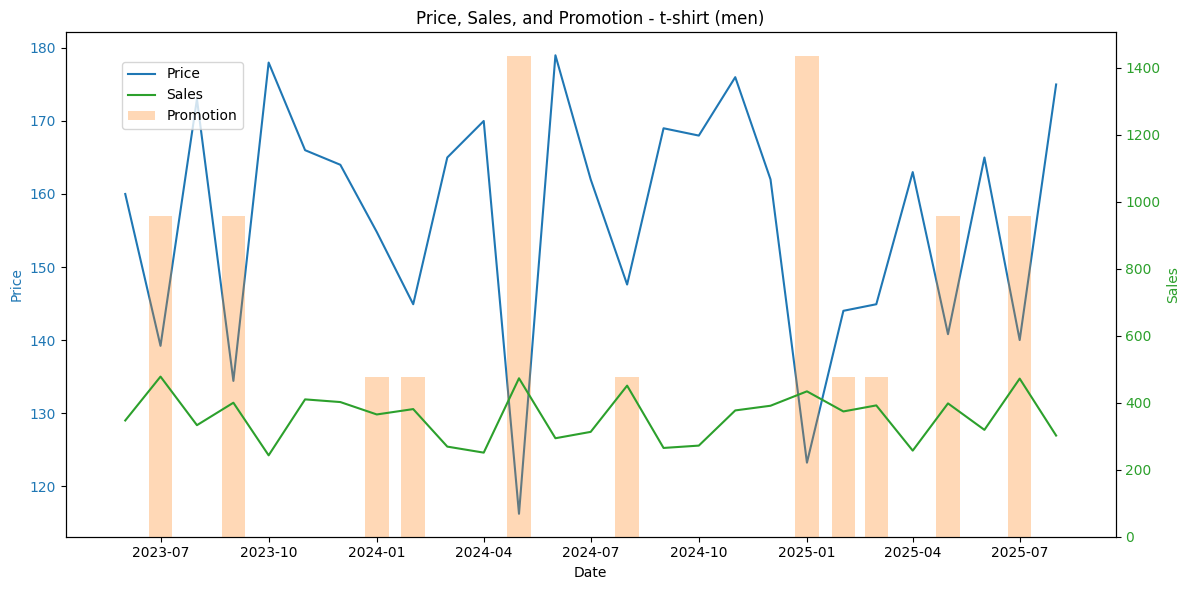

In [ ]:
import matplotlib.pyplot as plt
product='t-shirt'
category='men'
# Filter data

data = df_expanded.loc[(df_expanded['category']==category) & (df_expanded['product']==product)].copy()

# Sort by date (important for line plot)
data = data.sort_values("date")

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Price line
ax1.set_xlabel("Date")
ax1.set_ylabel("Price", color="tab:blue")
ax1.plot(data["date"], data["price"], color="tab:blue", label="Price")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Sales line (second axis)
ax2 = ax1.twinx()
ax2.set_ylabel("Sales", color="tab:green")
ax2.plot(data["date"], data["sales"], color="tab:green", label="Sales")
ax2.tick_params(axis="y", labelcolor="tab:green")

# Promotion bars
ax2.bar(
    data["date"],
    data["promotion"] * data["sales"].max() * 0.1,  # scale bar height
    width=20,
    alpha=0.3,
    color="tab:orange",
    label="Promotion"
)

# Legends
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.title(f"Price, Sales, and Promotion - {product} ({category})")
plt.tight_layout()
plt.show()


In [ ]:
df_expanded.to_csv("prices_data.csv",index=False)

In [ ]:
data

,id,product,category,date,price,promotion,seasonality,sales,sales_value,profit
27,1,t-shirt,men,2023-06-01,160.0,0.0,1.1,347.0,55474.0,28052.0
28,1,t-shirt,men,2023-07-01,139.2,20.0,1.1,478.0,66503.0,28717.0
29,1,t-shirt,men,2023-08-01,173.0,0.0,1.1,333.0,57661.0,31300.0
30,1,t-shirt,men,2023-09-01,134.4,20.0,0.9,400.0,53798.0,22139.0
31,1,t-shirt,men,2023-10-01,178.0,0.0,0.9,243.0,43281.0,24050.0
32,1,t-shirt,men,2023-11-01,166.0,0.0,1.3,410.0,67979.0,35590.0
33,1,t-shirt,men,2023-12-01,164.0,0.0,1.3,402.0,65952.0,34146.0
34,1,t-shirt,men,2024-01-01,154.8,10.0,0.9,365.0,56512.0,27639.0
35,1,t-shirt,men,2024-02-01,144.9,10.0,0.9,381.0,55194.0,25067.0
36,1,t-shirt,men,2024-03-01,165.0,0.0,0.9,269.0,44316.0,23073.0


# Function to show impact of price change given elasticity

In [ ]:
def simulate_demand(elasticity, discount = 0.1, P1=100, Q1=1000):
    """
    Simulate new demand and revenue given price change and elasticity.

    Parameters:
        elasticity (float): Price elasticity of demand (negative)
        discount (float): Discount (in range 0-1)
        P1 (float): Initial price
        Q1 (float): Initial quantity

    Returns:
        dict with new quantity, new revenue, % change in Q, % change in revenue
    """
    P2 = P1 * (1+discount)
    # % change in quantity
    pct_change_Q = elasticity * discount

    # new quantity
    Q2 = Q1 * (1 + pct_change_Q)

    # revenues
    R1 = P1 * Q1
    R2 = P2 * Q2

    return {
        "Initial Price": P1,
        "New Price": P2,
        "Initial Quantity": Q1,
        "New Quantity": round(Q2, 2),
        "Initial Revenue": round(R1, 2),
        "New Revenue": round(R2, 2),
        "% Change Quantity": round(pct_change_Q * 100, 2),
        "% Change Revenue": round(((R2 - R1) / R1) * 100, 2)
    }

# Example runs:
print(simulate_demand(-0.6, -0.1))
print(simulate_demand(-1.5, -0.1))

print(simulate_demand(-0.6, 0.1))
print(simulate_demand(-1.5, 0.1))


{'Initial Price': 100, 'New Price': 90.0, 'Initial Quantity': 1000, 'New Quantity': 1060.0, 'Initial Revenue': 100000, 'New Revenue': 95400.0, '% Change Quantity': 6.0, '% Change Revenue': -4.6}
{'Initial Price': 100, 'New Price': 90.0, 'Initial Quantity': 1000, 'New Quantity': 1150.0, 'Initial Revenue': 100000, 'New Revenue': 103500.0, '% Change Quantity': 15.0, '% Change Revenue': 3.5}
{'Initial Price': 100, 'New Price': 110.00000000000001, 'Initial Quantity': 1000, 'New Quantity': 940.0, 'Initial Revenue': 100000, 'New Revenue': 103400.0, '% Change Quantity': -6.0, '% Change Revenue': 3.4}
{'Initial Price': 100, 'New Price': 110.00000000000001, 'Initial Quantity': 1000, 'New Quantity': 850.0, 'Initial Revenue': 100000, 'New Revenue': 93500.0, '% Change Quantity': -15.0, '% Change Revenue': -6.5}


In [ ]:
print(simulate_demand(-0.9, -0.5))
print(simulate_demand(-1.1, -0.5))

{'Initial Price': 100, 'New Price': 50.0, 'Initial Quantity': 1000, 'New Quantity': 1450.0, 'Initial Revenue': 100000, 'New Revenue': 72500.0, '% Change Quantity': 45.0, '% Change Revenue': -27.5}
{'Initial Price': 100, 'New Price': 50.0, 'Initial Quantity': 1000, 'New Quantity': 1550.0, 'Initial Revenue': 100000, 'New Revenue': 77500.0, '% Change Quantity': 55.0, '% Change Revenue': -22.5}
